## Setup

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## MNIST
Basic dataset for classification (the "Hello World!" of ML)

In [4]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [5]:
X=mnist['data']
y=mnist['target']
some_digit = X[0]

In [6]:
y=y.astype(np.uint8)

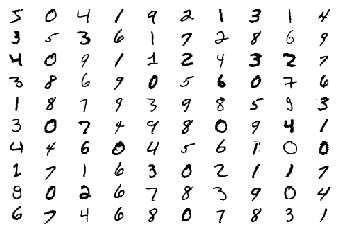

In [7]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digits = X[:100]
images=[]
for img in some_digits:
    images.append(img.reshape(28, 28))

for i in range(len(images)):
    plt.subplot(10, 10, i+1, frame_on=False, xmargin=0, ymargin=0), plt.imshow(images[i], 'binary')
    plt.xticks([]), plt.yticks([])

plt.axis()

plt.show()

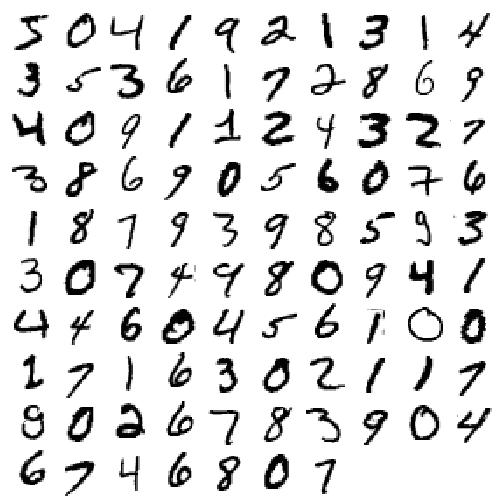

In [8]:
# better implementation

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
    

plt.figure(figsize=(9,9))
example_images = X[:97]
plot_digits(example_images, images_per_row=10)
plt.show()

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [10]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Binary Classifier

In [11]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Accuracy is not a good measure, as a trivial classifier that predicts every figure to be not 5 will also give 90% accuracy as the number of 5s in the dataset are that many only. Other criterias must be used.

### Confusion Matrix

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [15]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)
'''
    conf_mat=
    actual-->[[TN, FN],
              [FP, TP]]
              ^
              ^predictions
    so correctly predicted values are TN, TP
'''

'\n    conf_mat=\n    actual-->[[TN, FN],\n              [FP, TP]]\n              ^\n              ^predictions\n    so correctly predicted values are TN, TP\n'

precision = TP/(TP+FP)<BR>
recall = TP/(TP+FN)<BR>
f1_score = harmonic_mean(precision, recall)<br>
    
The F1 score favors classifiers that have similar precision and recall. This
is not always what you want: in some contexts you mostly care about
precision, and in other contexts you really care about recall. For example,
if you trained a classifier to detect videos that are safe for kids, you would
probably prefer a classifier that rejects many good videos (low recall) but
keeps only safe ones (high precision), rather than a classifier that has a
much higher recall but lets a few really bad videos show up in your
product (in such cases, you may even want to add a human pipeline to
check the classifier’s video selection). On the other hand, suppose you
train a classifier to detect shoplifters in surveillance images: it is probably
fine if your classifier has only 30% precision as long as it has 99% recall
(sure, the security guards will get a few false alerts, but almost all
shoplifters will get caught).

We can’t have it both ways: increasing precision reduces
recall, and vice versa. This is called the precision/recall trade-off.


In [16]:
from sklearn.metrics import precision_score, recall_score

print (precision_score(y_train_5, y_train_pred))
print (recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


In [17]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [18]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [19]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

Increasing threshold, increases precision(mostly), decreases recall (always)

In [20]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

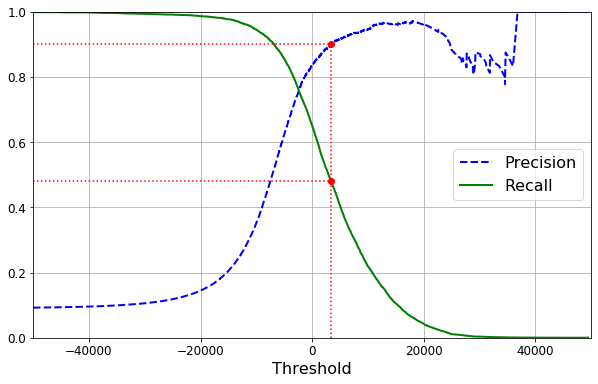

In [21]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], c='b', ls='--', label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], c='g', ls='-', label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])             

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

# (np.argmax() will give you the first index of the maximum
# value, which in this case means the first True value):


plt.figure(figsize=(10, 6))                      
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], c='r', ls=':')                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], c='r', ls=':')                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], c='r', ls=':')
plt.plot([threshold_90_precision], [0.9], c='r', marker='o')                                             
plt.plot([threshold_90_precision], [recall_90_precision], c='r', marker='o')                             
                                             
plt.show()

## ROC Curve
TPR(*recall*) vs FPR(1-*specificity*)<br>
Specificity = TNR i.e. ratio of negative instances that are actually classified as negative.

In [22]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

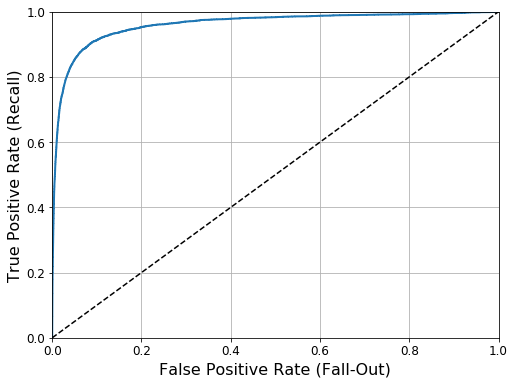

In [23]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                         
plot_roc_curve(fpr, tpr)
               
plt.show()

In [24]:
from sklearn.metrics import roc_auc_score # area under the auc curve

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

As a rule of thumb, you should prefer the PR curve
whenever the positive class is rare or when you care more about the false positives
than the false negatives. Otherwise, use the ROC curve

**Similarly, we can train on RandomForestClassifier model, and it turns out that it has higher roc_auc_score, precision as well as the recall value.<br>
*NOTE*: Using roc curve to determine the accuracy of this dataset is wrong (for binary classification). As there are less number of positive cases, p/r curve is prfered.**

## Multiclass Classification

In [25]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict([some_digit])

# NOTE: SciKit automatically choses between OvO and OvR classifiers, based on the size of the dataset.

array([5], dtype=uint8)

In [26]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [27]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [28]:
svm_clf.classes_[np.argmax(some_digit_scores)]

5

In [29]:
from sklearn.multiclass import OneVsRestClassifier
# purposely using One vs Rest Classifier

ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [30]:
# multi-classification by Scotastic Gradient Descent model

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [31]:
# improving efficiency by scaling the training set
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Error Analysis

In [32]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
y_train_pred

array([3, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [33]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

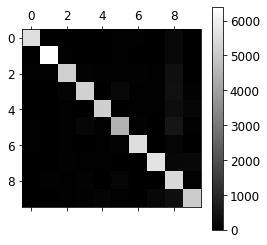

In [41]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.colorbar()

plt.show()

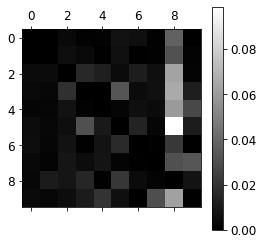

In [48]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
nrm_conf_mx = conf_mx / row_sums
np.fill_diagonal(nrm_conf_mx, 0)

plt.matshow(nrm_conf_mx, cmap=plt.cm.gray)
plt.colorbar()
plt.show()
# this shows many digits are classified as 8, but actual 8s are more or less classified as 8s only
# and 3s, 5s are being confused with each other

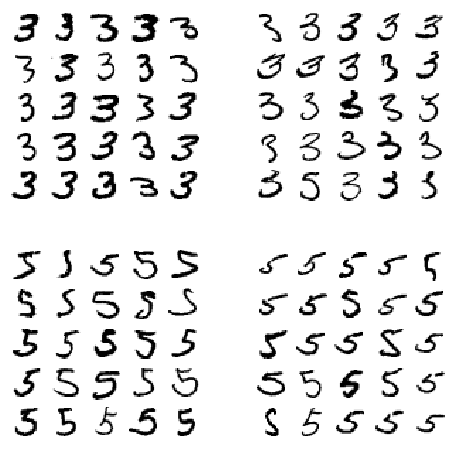

In [49]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

plt.show()
# actual\called| 3s 5s
#            3s   
#            5s

## Multilabel Classification
Each dataset having multiple binary labels

In [52]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

y_multilabel

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [ True, False]])

In [53]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [54]:
knn_clf.predict([some_digit])

array([[False,  True]])

## Multioutput Classification

Now in the multilabels case, if each class can have more than just two classes

Here each noisy image has 784 labels corresponding to each of its pixels, and each label can have values in range [0, 255]

In [55]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [69]:
def plot_digit(img):
    to_show = img.reshape(28, 28)
    plt.imshow(to_show, cmap='gray')
    plt.axis("off")

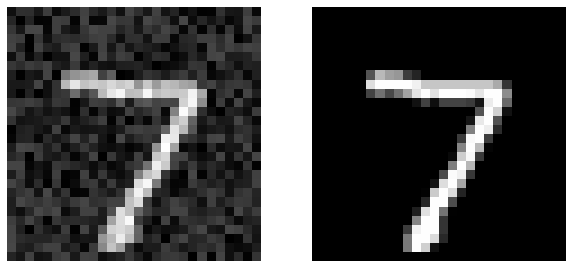

In [73]:
some_index = 0
plt.figure(figsize=(10, 10))
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])

plt.show()

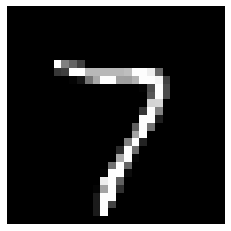

In [74]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)